In [1]:
from datasets import load_dataset
import json
from pathlib import Path
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor
from torchvision.transforms import ColorJitter
import numpy as np
from PIL import Image

# Load and prepare the dataset
ds = load_dataset("1aurent/ADE20K")
ds = ds.rename_column("segmentations", "annotation")
ds = ds.remove_columns(["filename", "folder", "source", "scene", "instances", "objects"])
train_ds = ds["train"]
val_ds = ds["validation"]

# Load labels
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.loads(Path(hf_hub_download(repo_id, filename, repo_type="dataset")).read_text())
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

# Set up image processor and color jitter
checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, do_reduce_labels=True)
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def preprocess_segmentation_map(segmentation_map):
    if isinstance(segmentation_map, list) and len(segmentation_map) > 0:
        segmentation_map = segmentation_map[0]
    
    if isinstance(segmentation_map, Image.Image):
        segmentation_map = np.array(segmentation_map)
    
    # Ensure the segmentation map is 2D
    if segmentation_map.ndim == 3:
        segmentation_map = segmentation_map[:, :, 0]
    
    return segmentation_map

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [preprocess_segmentation_map(x) for x in example_batch["annotation"]]
    inputs = image_processor(images, labels, return_tensors="pt")
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [preprocess_segmentation_map(x) for x in example_batch["annotation"]]
    inputs = image_processor(images, labels, return_tensors="pt")
    return inputs

# Apply transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

#train_ds = train_ds.select(range(100))
#val_ds = val_ds.select(range(100))

# Test the dataset
print(train_ds)
print(train_ds[0])

2024-11-04 10:11:38.069697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 10:11:38.086380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 10:11:38.091362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 10:11:38.103898: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 10:11:38.937072: W tensorflow/compiler/tf2

Dataset({
    features: ['image', 'annotation'],
    num_rows: 25574
})
{'pixel_values': tensor([[[-1.5014, -1.1589, -0.9534,  ..., -1.7754, -1.8097, -1.8610],
         [-1.4500, -1.1589, -0.9363,  ..., -1.7925, -1.8268, -1.8782],
         [-1.3815, -1.1589, -0.9192,  ..., -1.8097, -1.8439, -1.8953],
         ...,
         [-1.3130, -1.2959, -1.3815,  ..., -1.8782, -1.8953, -1.9124],
         [-1.3130, -1.2959, -1.3815,  ..., -1.8782, -1.8953, -1.9124],
         [-1.3130, -1.2959, -1.3815,  ..., -1.8782, -1.8953, -1.9124]],

        [[-1.0728, -0.6527, -0.4426,  ..., -1.5630, -1.5980, -1.6506],
         [-1.0378, -0.6877, -0.4601,  ..., -1.5805, -1.6155, -1.6681],
         [-0.9853, -0.7402, -0.4776,  ..., -1.5980, -1.6331, -1.6856],
         ...,
         [-0.9853, -0.9328, -0.9853,  ..., -1.6856, -1.6856, -1.7031],
         [-0.9853, -0.9328, -0.9853,  ..., -1.6856, -1.6856, -1.7031],
         [-0.9853, -0.9328, -0.9853,  ..., -1.6856, -1.6856, -1.7031]],

        [[-0.7587, -0.3404,

In [2]:
import evaluate
import numpy as np
import torch
from torch import nn

metric = evaluate.load("mean_iou")
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if isinstance(value, np.ndarray):
                metrics[key] = value.tolist()
        return metrics

In [3]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer, TrainerCallback
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)

training_args = TrainingArguments(
    output_dir="segformer-b0-scene-parse-150",
    learning_rate=6e-5,
    max_grad_norm=0.1,
    num_train_epochs=10,
    per_device_train_batch_size=1,
    save_total_limit=3,
    save_strategy="epoch",
    eval_strategy="steps",  # Change to "steps" for step-based evaluation
    eval_steps=1000,  # Evaluate every 1000 steps
    remove_unused_columns=False,
    fp16=True,
    dataloader_num_workers=6,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/eagle/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:469: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.

Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.17 GiB. GPU 0 has a total capacity of 7.78 GiB of which 1.16 GiB is free. Including non-PyTorch memory, this process has 5.90 GiB memory in use. Of the allocated memory 5.63 GiB is allocated by PyTorch, and 91.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

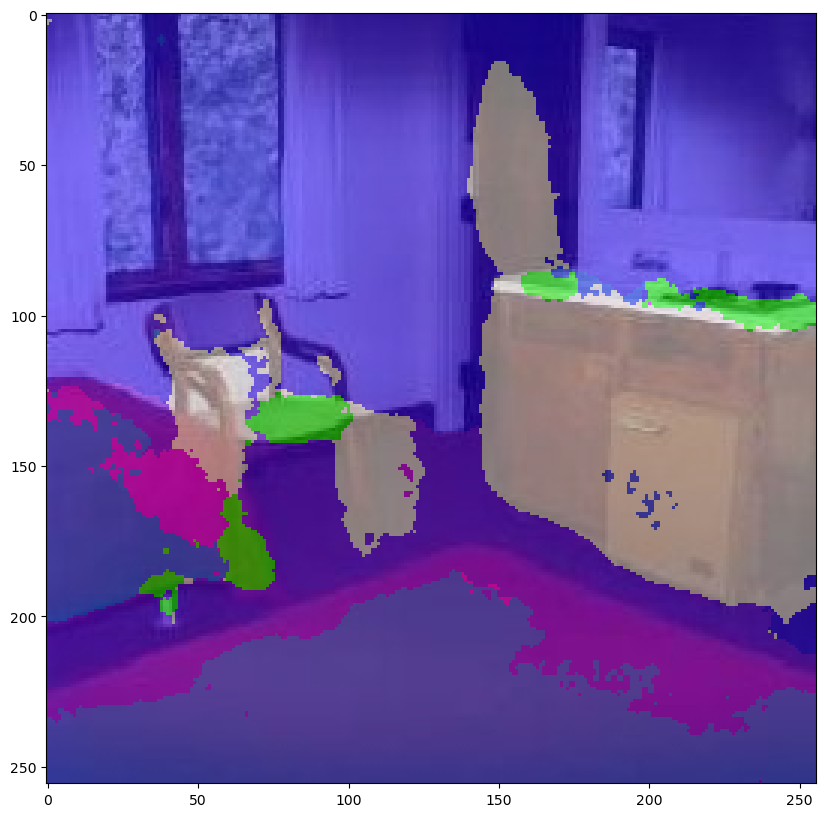

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

ds = load_dataset("1aurent/ADE20K")

test_ds = ds["validation"]
image = ds["validation"][200]["image"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)

outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

def ade_palette():
  return np.asarray([[0, 0, 0], [120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
      [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255], [230, 230, 230], [4, 250, 7],
      [224, 5, 255], [235, 255, 7], [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()